In [1]:
# 0. 패키지 불러오기
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.utils import np_utils

# 랜덤시드 고정시키기
np.random.seed(5)

# 손실 이력 클래스 정의
class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

# 데이터셋 생성 함수
def seq2dataset(seq, window_size):
    dataset_X = []
    dataset_Y = []

    for i in range(len(seq)-window_size):

        subset = seq[i:(i+window_size+1)]

        for si in range(len(subset)-1):
            features = code2features(subset[si])
            dataset_X.append(features)

        dataset_Y.append([code2idx[subset[window_size]]])

    return np.array(dataset_X), np.array(dataset_Y)

# 속성 변환 함수
def code2features(code):
    features = []
    features.append(code2scale[code[0]]/float(max_scale_value))
    features.append(code2oct[code[1]])
    features.append(code2length[code[2]])
    features.append(code2legato[code[3]])
    return features

def codeExpander(orig):
    res = []
    for i in range(len(orig)):
        source = seq[i]
        translate = ''
        if source[0] in 'cdefgab':
            translate += source[0].upper()
            if source[1] == '0':
                translate += '_Octave0_'
            elif source[1] == '1':
                translate += '_Octave1_'
            else:
                translate += '_Octave2_'
            if source[2] == '1':
                translate += 'length1'
            elif source[2] == '2':
                translate += 'length2'
            else:
                translate += 'length3'
            if source[3] in 'se':
                if source[3] == 's':
                    translate += '_legatoStart'
                else:
                    translate += '_legatoEnd'
        else:
            translate = 'Pause_1'
        res.append(translate)
    return res


# 1. 데이터 준비하기

# 코드 사전 정의
code2scale = {'c':0, 'd':1, 'e':2, 'f':3, 'g':4, 'a':5, 'b':6, 'x':7}
code2oct = {'0':0, '1':1, '2':2}
code2length = {'1':0, '2':1, '3':2}
code2legato = {'n':0, 's':1, 'e':2} #none, start, end

max_scale_value = 7.0

# 시퀀스 데이터 정의 (c100 - note+octave+length+legato)
code2idx = {'c11n':0, 'd11n':1, 'e11n':2, 'f11n':3, 'g11n':4, 'a11n':5, 'b11n':6, \
            'c12n':7, 'd12n':8, 'e12n':9, 'f12n':10, 'g12n':11, 'a12n':12, 'b12n':13, \
            'c13n':14, 'd13n':15, 'e13n':16, 'f13n':17, 'g13n':18, 'a13n':19, 'b13n':20, \
            'c21n':21, 'd21n':22, 'e21n':23, 'f21n':24, 'g21n':25, 'a21n':26, 'b21n':27, \
            'c22n':28, 'd22n':29, 'e22n':30, 'f22n':31, 'g22n':32, 'a22n':33, 'b22n':34, \
            'c23n':35, 'd23n':36, 'e23n':37, 'f23n':38, 'g23n':39, 'a23n':40, 'b23n':41, \
            'c01n':42, 'd01n':43, 'e01n':44, 'f01n':45, 'g01n':46, 'a01n':47, 'b01n':48, \
            'c02n':49, 'd02n':50, 'e02n':51, 'f02n':52, 'g02n':53, 'a02n':54, 'b02n':55, \
            'c03n':56, 'd03n':57, 'e03n':58, 'f03n':59, 'g03n':60, 'a03n':61, 'b03n':62, \
            'c11s':63, 'd11s':64, 'e11s':65, 'f11s':66, 'g11s':67, 'a11s':68, 'b11s':69, \
            'c12s':70, 'd12s':71, 'e12s':72, 'f12s':73, 'g12s':74, 'a12s':75, 'b12s':76, \
            'c13s':77, 'd13s':78, 'e13s':79, 'f13s':80, 'g13s':81, 'a13s':82, 'b13s':83, \
            'c11e':84, 'd11e':85, 'e11e':86, 'f11e':87, 'g11e':88, 'a11e':89, 'b11e':90, \
            'c12e':91, 'd12e':92, 'e12e':93, 'f12e':94, 'g12e':95, 'a12e':96, 'b12e':97, \
            'c13e':98, 'd13e':99, 'e13e':100, 'f13e':101, 'g13e':102, 'a13e':103, 'b13e':104, \
            'c21s':105, 'd21s':106, 'e21s':107, 'f21s':108, 'g21s':109, 'a21s':110, 'b21s':111, \
            'c22s':112, 'd22s':113, 'e22s':114, 'f22s':115, 'g22s':116, 'a22s':117, 'b22s':118, \
            'c23s':119, 'd23s':120, 'e23s':121, 'f23s':122, 'g23s':123, 'a23s':124, 'b22s':125, \
            'c21e':126, 'd21e':127, 'e21e':128, 'f21e':129, 'g21e':130, 'a21e':131, 'b21e':132, \
            'c22e':133, 'd22e':134, 'e22e':135, 'f22e':136, 'g22e':137, 'a22e':138, 'b22e':139, \
            'c23e':140, 'd23e':141, 'e23e':142, 'f23e':143, 'g23e':144, 'a23e':145, 'b23e':146, \
            'x01n': 147}

idx2code = {y:x for x,y in code2idx.items()}


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# 시퀀스 데이터 정의
seq = ['a13n', 'd22n', 'c21n', 'b12n', 'd21n', 'a12s', 'a11e', 'd12s','e11e', 'f12n', 'b11n', 'a13s', 'a12e', 'x01n', 'f12s', 'f11e', 'b12n', 'd21n', 'a12n', 'g11n', 'f13n', 'g12n', 'f11n', 'e11n', 'b11n', 'a11n', 'd13s', 'd12e', 'x01n', 'e12s', 'f11e', 'g12n', 'f11n', 'e11s', 'd11e', 'c11n', 'b03n', 'd12n', 'e11n', 'f12n', 'b11n', 'a13s', 'a12e', 'x01n', 'd22s', 'c21e', 'e22n', 'd21n', 'c21n', 'b11n', 'a11n', 'f13n', 'e11n', 'b11n', 'a11n', 'e11n', 'g11n', 'f11n', 'd13s', 'd12e', 'x01n']

# 2. 데이터셋 생성하기
x_train, y_train = seq2dataset(seq, window_size = 4)

In [3]:
# 입력을 (샘플 수, 타임스텝, 특성 수)로 형태 변환
x_train = np.reshape(x_train, (57, 4, 4))

# 라벨값에 대한 one-hot 인코딩 수행
y_train = np_utils.to_categorical(y_train)

one_hot_vec_size = y_train.shape[1]

print("one hot encoding vector size is ", one_hot_vec_size)

one hot encoding vector size is  148


epochs : 0
Epoch 1/1
 - 2s - loss: 4.6519 - acc: 0.0526
epochs : 1
Epoch 1/1
 - 1s - loss: 3.6856 - acc: 0.0877
epochs : 2
Epoch 1/1
 - 1s - loss: 3.4933 - acc: 0.1228
epochs : 3
Epoch 1/1
 - 1s - loss: 3.4375 - acc: 0.1228
epochs : 4
Epoch 1/1
 - 1s - loss: 3.3975 - acc: 0.1404
epochs : 5
Epoch 1/1
 - 1s - loss: 3.3406 - acc: 0.1053
epochs : 6
Epoch 1/1
 - 1s - loss: 3.2219 - acc: 0.1404
epochs : 7
Epoch 1/1
 - 1s - loss: 3.0839 - acc: 0.1579
epochs : 8
Epoch 1/1
 - 1s - loss: 3.0223 - acc: 0.1754
epochs : 9
Epoch 1/1
 - 1s - loss: 2.7945 - acc: 0.2105
epochs : 10
Epoch 1/1
 - 1s - loss: 2.5616 - acc: 0.1754
epochs : 11
Epoch 1/1
 - 1s - loss: 2.2927 - acc: 0.2982
epochs : 12
Epoch 1/1
 - 1s - loss: 2.5304 - acc: 0.2281
epochs : 13
Epoch 1/1
 - 1s - loss: 2.9457 - acc: 0.2456
epochs : 14
Epoch 1/1
 - 1s - loss: 2.1955 - acc: 0.3333
epochs : 15
Epoch 1/1
 - 1s - loss: 2.0212 - acc: 0.2807
epochs : 16
Epoch 1/1
 - 1s - loss: 1.8944 - acc: 0.3684
epochs : 17
Epoch 1/1
 - 1s - loss: 1.558

epochs : 141
Epoch 1/1
 - 1s - loss: 3.0969e-04 - acc: 1.0000
epochs : 142
Epoch 1/1
 - 1s - loss: 2.9906e-04 - acc: 1.0000
epochs : 143
Epoch 1/1
 - 1s - loss: 2.8958e-04 - acc: 1.0000
epochs : 144
Epoch 1/1
 - 1s - loss: 2.7923e-04 - acc: 1.0000
epochs : 145
Epoch 1/1
 - 1s - loss: 2.7083e-04 - acc: 1.0000
epochs : 146
Epoch 1/1
 - 1s - loss: 2.6152e-04 - acc: 1.0000
epochs : 147
Epoch 1/1
 - 1s - loss: 2.5319e-04 - acc: 1.0000
epochs : 148
Epoch 1/1
 - 1s - loss: 2.4472e-04 - acc: 1.0000
epochs : 149
Epoch 1/1
 - 1s - loss: 2.3710e-04 - acc: 1.0000
epochs : 150
Epoch 1/1
 - 1s - loss: 2.2886e-04 - acc: 1.0000
epochs : 151
Epoch 1/1
 - 1s - loss: 2.2167e-04 - acc: 1.0000
epochs : 152
Epoch 1/1
 - 1s - loss: 2.1418e-04 - acc: 1.0000
epochs : 153
Epoch 1/1
 - 1s - loss: 2.0763e-04 - acc: 1.0000
epochs : 154
Epoch 1/1
 - 1s - loss: 2.0073e-04 - acc: 1.0000
epochs : 155
Epoch 1/1
 - 1s - loss: 1.9443e-04 - acc: 1.0000
epochs : 156
Epoch 1/1
 - 1s - loss: 1.8804e-04 - acc: 1.0000
epochs :

 - 1s - loss: 5.2170e-06 - acc: 1.0000
epochs : 274
Epoch 1/1
 - 1s - loss: 5.0978e-06 - acc: 1.0000
epochs : 275
Epoch 1/1
 - 1s - loss: 4.9158e-06 - acc: 1.0000
epochs : 276
Epoch 1/1
 - 1s - loss: 4.8039e-06 - acc: 1.0000
epochs : 277
Epoch 1/1
 - 1s - loss: 4.6387e-06 - acc: 1.0000
epochs : 278
Epoch 1/1
 - 1s - loss: 4.5195e-06 - acc: 1.0000
epochs : 279
Epoch 1/1
 - 1s - loss: 4.3773e-06 - acc: 1.0000
epochs : 280
Epoch 1/1
 - 1s - loss: 4.2455e-06 - acc: 1.0000
epochs : 281
Epoch 1/1
 - 1s - loss: 4.1169e-06 - acc: 1.0000
epochs : 282
Epoch 1/1
 - 1s - loss: 4.0050e-06 - acc: 1.0000
epochs : 283
Epoch 1/1
 - 1s - loss: 3.8900e-06 - acc: 1.0000
epochs : 284
Epoch 1/1
 - 1s - loss: 3.7645e-06 - acc: 1.0000
epochs : 285
Epoch 1/1
 - 1s - loss: 3.6579e-06 - acc: 1.0000
epochs : 286
Epoch 1/1
 - 1s - loss: 3.5554e-06 - acc: 1.0000
epochs : 287
Epoch 1/1
 - 1s - loss: 3.4487e-06 - acc: 1.0000
epochs : 288
Epoch 1/1
 - 1s - loss: 3.3379e-06 - acc: 1.0000
epochs : 289
Epoch 1/1
 - 1s - 

epochs : 406
Epoch 1/1
 - 1s - loss: 1.3699e-07 - acc: 1.0000
epochs : 407
Epoch 1/1
 - 1s - loss: 1.3699e-07 - acc: 1.0000
epochs : 408
Epoch 1/1
 - 1s - loss: 1.3594e-07 - acc: 1.0000
epochs : 409
Epoch 1/1
 - 1s - loss: 1.3489e-07 - acc: 1.0000
epochs : 410
Epoch 1/1
 - 1s - loss: 1.3280e-07 - acc: 1.0000
epochs : 411
Epoch 1/1
 - 1s - loss: 1.3280e-07 - acc: 1.0000
epochs : 412
Epoch 1/1
 - 1s - loss: 1.2757e-07 - acc: 1.0000
epochs : 413
Epoch 1/1
 - 1s - loss: 1.2548e-07 - acc: 1.0000
epochs : 414
Epoch 1/1
 - 1s - loss: 1.2757e-07 - acc: 1.0000
epochs : 415
Epoch 1/1
 - 1s - loss: 1.2548e-07 - acc: 1.0000
epochs : 416
Epoch 1/1
 - 1s - loss: 1.2548e-07 - acc: 1.0000
epochs : 417
Epoch 1/1
 - 1s - loss: 1.2339e-07 - acc: 1.0000
epochs : 418
Epoch 1/1
 - 1s - loss: 1.2339e-07 - acc: 1.0000
epochs : 419
Epoch 1/1
 - 1s - loss: 1.2130e-07 - acc: 1.0000
epochs : 420
Epoch 1/1
 - 1s - loss: 1.2339e-07 - acc: 1.0000
epochs : 421
Epoch 1/1
 - 1s - loss: 1.2130e-07 - acc: 1.0000
epochs :

 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 539
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 540
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 541
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 542
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 543
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 544
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 545
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 546
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 547
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 548
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 549
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 550
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 551
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 552
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 553
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 554
Epoch 1/1
 - 1s - 

epochs : 671
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 672
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 673
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 674
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 675
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 676
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 677
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 678
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 679
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 680
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 681
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 682
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 683
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 684
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 685
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 686
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs :

 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 804
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 805
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 806
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 807
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 808
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 809
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 810
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 811
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 812
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 813
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 814
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 815
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 816
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 817
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 818
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 819
Epoch 1/1
 - 1s - 

epochs : 936
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 937
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 938
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 939
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 940
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 941
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 942
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 943
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 944
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 945
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 946
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 947
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 948
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 949
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 950
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 951
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs :

 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1068
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1069
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1070
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1071
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1072
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1073
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1074
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1075
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1076
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1077
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1078
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1079
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1080
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1081
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1082
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1083
Ep

epochs : 1198
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1199
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1200
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1201
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1202
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1203
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1204
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1205
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1206
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1207
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1208
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1209
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1210
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1211
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1212
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1213
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc:

 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1329
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1330
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1331
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1332
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1333
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1334
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1335
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1336
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1337
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1338
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1339
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1340
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1341
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1342
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1343
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1344
Ep

epochs : 1459
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1460
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1461
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1462
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1463
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1464
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1465
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1466
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1467
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1468
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1469
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1470
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1471
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1472
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1473
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1474
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc:

 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1590
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1591
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1592
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1593
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1594
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1595
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1596
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1597
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1598
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1599
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1600
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1601
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1602
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1603
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1604
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1605
Ep

epochs : 1720
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1721
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1722
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1723
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1724
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1725
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1726
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1727
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1728
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1729
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1730
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1731
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1732
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1733
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1734
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1735
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc:

 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1851
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1852
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1853
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1854
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1855
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1856
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1857
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1858
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1859
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1860
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1861
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1862
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1863
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1864
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1865
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1866
Ep

epochs : 1981
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1982
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1983
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1984
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1985
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1986
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1987
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1988
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1989
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1990
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1991
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1992
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1993
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1994
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1995
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1996
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc:

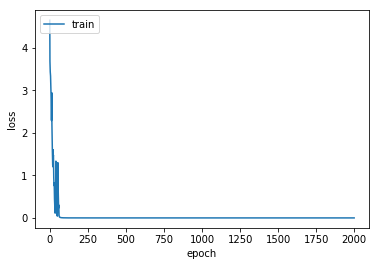

57/57 [==============================] - 0s 6ms/step
acc: 100.00%
one step prediction :  ['a13n', 'd22n', 'c21n', 'b12n', 'd21n', 'a12s', 'a11e', 'd12s', 'e11e', 'f12n', 'b11n', 'a13s', 'a12e', 'x01n', 'f12s', 'f11e', 'b12n', 'd21n', 'a12n', 'g11n', 'f13n', 'g12n', 'f11n', 'e11n', 'b11n', 'a11n', 'd13s', 'd12e', 'x01n', 'e12s', 'f11e', 'g12n', 'f11n', 'e11s', 'd11e', 'c11n', 'b03n', 'd12n', 'e11n', 'f12n', 'b11n', 'a13s', 'a12e', 'x01n', 'd22s', 'c21e', 'e22n', 'd21n', 'c21n', 'b11n', 'a11n', 'f13n', 'e11n', 'b11n', 'a11n', 'e11n', 'g11n', 'f11n', 'd13s', 'd12e', 'x01n']
Expanded code :  ['A_Octave1_length3', 'D_Octave2_length2', 'C_Octave2_length1', 'B_Octave1_length2', 'D_Octave2_length1', 'A_Octave1_length2_legatoStart', 'A_Octave1_length1_legatoEnd', 'D_Octave1_length2_legatoStart', 'E_Octave1_length1_legatoEnd', 'F_Octave1_length2', 'B_Octave1_length1', 'A_Octave1_length3_legatoStart', 'A_Octave1_length2_legatoEnd', 'Pause_1', 'F_Octave1_length2_legatoStart', 'F_Octave1_length1_le

In [9]:
# 3. 모델 구성하기
model = Sequential()
model.add(LSTM(350, batch_input_shape = (1, 4, 4), stateful=True))
model.add(Dense(one_hot_vec_size, activation='softmax'))

# 4. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 5. 모델 학습시키기
num_epochs = 2000

history = LossHistory() # 손실 이력 객체 생성
history.init()

for epoch_idx in range(num_epochs):
    print ('epochs : ' + str(epoch_idx) )
    model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2, shuffle=False, callbacks=[history]) # 50 is X.shape[0]
    model.reset_states()

# 6. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# 7. 모델 평가하기
scores = model.evaluate(x_train, y_train, batch_size=1)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))
model.reset_states()

# 8. 모델 사용하기
pred_count = 57 # 최대 예측 개수 정의

# 한 스텝 예측
seq_out = ['a13n', 'd22n', 'c21n', 'b12n']
pred_out = model.predict(x_train, batch_size=1)

for i in range(pred_count):
    idx = np.argmax(pred_out[i]) # one-hot 인코딩을 인덱스 값으로 변환
    seq_out.append(idx2code[idx]) # seq_out는 최종 악보이므로 인덱스 값을 코드로 변환하여 저장

print("one step prediction : ", seq_out)
print("="*80)
print("Expanded code : ", codeExpander(seq_out), '\n\n')

model.reset_states()

# 곡 전체 예측
seq_in = ['a13n', 'd22n', 'c21n', 'b12n']
seq_out = seq_in

seq_in_featrues = []

for si in seq_in:
    features = code2features(si)
    seq_in_featrues.append(features)

for i in range(pred_count):
    sample_in = np.array(seq_in_featrues)
    sample_in = np.reshape(sample_in, (1, 4, 4)) # 샘플 수, 타입스텝 수, 속성 수
    pred_out = model.predict(sample_in)
    idx = np.argmax(pred_out)
    seq_out.append(idx2code[idx])

    features = code2features(idx2code[idx])
    seq_in_featrues.append(features)
    seq_in_featrues.pop(0)

model.reset_states()

print("full song prediction : ", seq_out)
print("="*80)
print("Expanded code : ", codeExpander(seq_out))

Result(MLP)


